In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  #close copy warning   

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier

In [2]:
property_df = pd.read_csv("../data/curated/data.csv")

In [3]:
print(list(property_df.columns))

['address', 'rent_weekly', 'floor', 'suburb', 'postcode', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'coordinates', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation', 'cloest_train_station', 'cloest_SECON

In [4]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

property_df['type'] = property_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
property_df['type'] = property_df['type'].replace('Studio', 2)
property_df['type'] = property_df['type'].replace('Townhouse','House')
property_df['type'] = property_df['type'].replace('House', 3)
property_df = convert_suburb(property_df)

property_df = property_df.drop(columns=['postcode'])
property_df = property_df.fillna(-1)



In [5]:
property_df

address  rent_weekly  floor  suburb  type   furnitured  pool   gym    num_bed  num_bath  num_car_park  coordinates  SECONDARY SCHOOL  PRIMARY AND SECONDARY SCHOOL  PRIMARY SCHOOL  SHOPPING CENTRE  PARK   KINDERGARTEN  POST OFFICE  SPECIAL SCHOOL  CHILD CARE  BAR    SPORTS COMPLEX  EDUCATION COMPLEX  CEMETERY  LIBRARY  UNIVERSITY  GENERAL HOSPITAL  POLICE STATION  FURTHER EDUCATION  PLAYGROUND  PLANTATION  WINERY  FARM   VINEYARD  TENNIS COURT  BAY    PIER   SWIMMING POOL  ART GALLERY  HARBOUR  COMMUNITY HEALTH CENTRE  MARKET  PRISON  BOTANIC GARDENS  SPECIALISED HOSPITAL  BANK   AGED CARE  SURFING SPOT  COAST  GOLF COURSE  HELIPORT  AIRPORT  IRON ORE PROCESSOR  MILL/TIMBER OPERATIONS  BEACH  TRAIN STATION  TRAM STATION  BUS    Education  Commercial  Environment  Medication  Secrity  Industrial  Prison  Transportation  cloest_train_station  cloest_SECONDARY SCHOOL  cloest_PRIMARY AND SECONDARY SCHOOL  cloest_PRIMARY SCHOOL  cloest_SHOPPING CENTRE  cloest_PARK  cloest_KINDERGARTEN  cloes

In [ ]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [6]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(20)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
type,0.120412
Secrity,0.117222
POLICE STATION,0.117222
TRAIN STATION,0.113993


In [7]:
internal = property_df[['address', 'rent_weekly', 'floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park']]
external = property_df[['address', 'rent_weekly','SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS']]
dimension = property_df[['address', 'rent_weekly','Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation']]

In [8]:
internal.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
type,0.120412
gym,0.109401
floor,0.101841
num_bed,0.093900
pool,0.091041
suburb,0.087228
num_car_park,0.082851
furnitured,0.036077
num_bath,0.025824


In [ ]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(internal.corr())
fig.figure.savefig('../plots/heatmap_internal.png',bbox_inches = 'tight')

In [9]:
internal[internal['type'] == 1].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
suburb,0.140465
gym,0.126772
pool,0.102632
floor,0.101654
num_car_park,0.052256
num_bath,0.049523
num_bed,0.041645
furnitured,0.037907
type,NaN


In [10]:
internal[internal['type'] == 3].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
num_car_park,0.032713
pool,0.023810
suburb,0.023093
num_bed,0.015205
floor,0.008797
gym,0.008449
furnitured,0.003345
num_bath,0.002202
type,NaN


In [11]:
external.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
POLICE STATION,0.117222
TRAIN STATION,0.113993
BOTANIC GARDENS,0.096230
SECONDARY SCHOOL,0.091323
GENERAL HOSPITAL,0.086397


In [ ]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(external.corr())
fig.figure.savefig('../plots/heatmap_external.png',bbox_inches = 'tight')

In [12]:
dimension.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
Commercial,0.156781
Secrity,0.117222
Medication,0.083742
Transportation,0.068083
Prison,0.066797
Environment,0.050913
Education,0.049204
Industrial,0.032781


In [ ]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(dimension.corr())
fig.figure.savefig('../plots/heatmap_dimension.png',bbox_inches = 'tight')

In [13]:
col_lis = ['floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Transportation', 'cloest_SECONDARY SCHOOL', 'cloest_PRIMARY AND SECONDARY SCHOOL', 'cloest_PRIMARY SCHOOL', 'cloest_SHOPPING CENTRE', 'cloest_PARK', 'cloest_KINDERGARTEN', 'cloest_POST OFFICE', 'cloest_SPECIAL SCHOOL', 'cloest_CHILD CARE', 'cloest_BAR', 'cloest_SPORTS COMPLEX', 'cloest_EDUCATION COMPLEX', 'cloest_CEMETERY', 'cloest_LIBRARY', 'cloest_UNIVERSITY', 'cloest_GENERAL HOSPITAL', 'cloest_POLICE STATION', 'cloest_FURTHER EDUCATION', 'cloest_PLAYGROUND', 'cloest_PLANTATION', 'cloest_WINERY', 'cloest_FARM', 'cloest_VINEYARD', 'cloest_TENNIS COURT', 'cloest_BAY', 'cloest_PIER', 'cloest_SWIMMING POOL', 'cloest_ART GALLERY', 'cloest_HARBOUR', 'cloest_COMMUNITY HEALTH CENTRE', 'cloest_MATERNAL AND CHILD HEALTH CENTRE', 'cloest_MARKET', 'cloest_PRISON', 'cloest_BOTANIC GARDENS', 'cloest_SPECIALISED HOSPITAL', 'cloest_BANK', 'cloest_AGED CARE', 'cloest_SURFING SPOT', 'cloest_COAST', 'cloest_GOLF COURSE', 'cloest_HELIPORT', 'cloest_AIRPORT', 'cloest_IRON ORE PROCESSOR', 'cloest_MILL/TIMBER OPERATIONS', 'cloest_BEACH', 'cloest_TRAM STATION', 'cloest_BUS', 'cloest_TRAIN_STATION_duration', 'cloest_TRAIN_STATION_distance']
X = property_df[col_lis].copy()
y = property_df['rent_weekly']
X_norm = MinMaxScaler().fit_transform(X)

In [14]:
mi_selector = SelectKBest(mutual_info_classif, k=15)
mi_selector.fit(X, y)
mi_scores = mi_selector.scores_
mi_support = mi_selector.get_support()
mi_feature = X.loc[:,mi_support].columns.tolist()
idx = [x for x in range(len(mi_support)) if mi_support[x]]
score = {}
for i in idx:
    score[col_lis[i]] = mi_scores[i]
pd.DataFrame.from_dict({'features':score.keys(), 'mi_value':score.values()}).sort_values(by=['mi_value'], ascending=False)

,features,mi_value
0,suburb,0.186769
9,cloest_BANK,0.102648
12,cloest_COAST,0.095740
11,cloest_SURFING SPOT,0.088554
10,cloest_AGED CARE,0.085105
7,cloest_PRISON,0.084524
8,cloest_SPECIALISED HOSPITAL,0.080382
2,Transportation,0.077781
3,cloest_TENNIS COURT,0.073535
4,cloest_ART GALLERY,0.073334


In [15]:
chi_selector = SelectKBest(chi2, k=15)
chi_selector.fit(X_norm, y)
chi_scores = chi_selector.scores_
chi_pvalues = chi_selector.pvalues_
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
idx = [x for x in range(len(chi_support)) if chi_support[x]]
score = {}
for i in idx:
    score[col_lis[i]] = chi_scores[i]
print(score)

pvalue = {}
for i in idx:
    pvalue[col_lis[i]] = chi_pvalues[i]
print(pvalue)

pd.DataFrame.from_dict({'features':score.keys(), 'chi2_value':score.values()}).sort_values(by=['chi2_value'], ascending=False)

{'furnitured': 337.87520193832256, 'pool': 411.683649396211, 'gym': 470.6203685340238, 'POST OFFICE': 278.50359442529583, 'BAR': 323.1257806418002, 'SPORTS COMPLEX': 370.9612416196758, 'UNIVERSITY': 245.15242936719983, 'MARKET': 440.6735061157669, 'PRISON': 280.8483981454798, 'BOTANIC GARDENS': 377.9231475204045, 'SPECIALISED HOSPITAL': 270.04275121613745, 'BANK': 423.93905745138017, 'AIRPORT': 265.9485149357361, 'TRAM STATION': 361.7166805637459, 'Commercial': 267.8671762048476}
{'furnitured': 6.5274812019246514e-09, 'pool': 1.8730038623850685e-16, 'gym': 1.7304404709667688e-23, 'POST OFFICE': 0.000288383414893084, 'BAR': 1.278831760349823e-07, 'SPORTS COMPLEX': 4.3394908837676094e-12, 'UNIVERSITY': 0.020512837298848535, 'MARKET': 8.080540767763871e-20, 'PRISON': 0.00020275639302502416, 'BOTANIC GARDENS': 8.401018788117538e-13, 'SPECIALISED HOSPITAL': 0.0009734716735017774, 'BANK': 7.481273516333391e-18, 'AIRPORT': 0.0016993160747771228, 'TRAM STATION': 3.642666242704972e-11, 'Commerc

,features,chi2_value
2,gym,470.620369
7,MARKET,440.673506
11,BANK,423.939057
1,pool,411.683649
9,BOTANIC GARDENS,377.923148
5,SPORTS COMPLEX,370.961242
13,TRAM STATION,361.716681
0,furnitured,337.875202
4,BAR,323.125781
8,PRISON,280.848398


In [16]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,15)
print(str(len(cor_feature)), 'selected features')

15 selected features


d:\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
rfe_selector = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 112 features.
Fitting estimator with 102 features.
Fitting estimator with 92 features.
Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.


['furnitured',
 'pool',
 'num_car_park',
 'SECONDARY SCHOOL',
 'SHOPPING CENTRE',
 'SPECIAL SCHOOL',
 'UNIVERSITY',
 'COMMUNITY HEALTH CENTRE',
 'PRISON',
 'TRAIN STATION',
 'TRAM STATION',
 'Secrity',
 'cloest_TRAM STATION',
 'cloest_BUS',
 'cloest_TRAIN_STATION_duration']

In [18]:
embeded_lr_selector = SelectFromModel(LogisticRegression(solver='liblinear',penalty="l1",max_iter=10000), max_features=15)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

embeded_lr_feature

['suburb',
 'type',
 'furnitured',
 'pool',
 'num_car_park',
 'SECONDARY SCHOOL',
 'SHOPPING CENTRE',
 'SPECIAL SCHOOL',
 'CEMETERY',
 'UNIVERSITY',
 'FURTHER EDUCATION',
 'COMMUNITY HEALTH CENTRE',
 'PRISON',
 'TRAIN STATION',
 'cloest_TRAM STATION']

In [19]:
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 50, random_state = 50), max_features=15)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
embeded_rf_feature


['floor',
 'cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_SHOPPING CENTRE',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_CHILD CARE',
 'cloest_BAY',
 'cloest_HARBOUR',
 'cloest_PRISON',
 'cloest_BANK',
 'cloest_AGED CARE',
 'cloest_SURFING SPOT',
 'cloest_BEACH',
 'cloest_BUS']

In [20]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=15)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
embeded_lgb_feature

['cloest_SECONDARY SCHOOL',
 'cloest_PRIMARY SCHOOL',
 'cloest_PARK',
 'cloest_KINDERGARTEN',
 'cloest_POST OFFICE',
 'cloest_CHILD CARE',
 'cloest_SPORTS COMPLEX',
 'cloest_UNIVERSITY',
 'cloest_GENERAL HOSPITAL',
 'cloest_POLICE STATION',
 'cloest_PLAYGROUND',
 'cloest_VINEYARD',
 'cloest_SWIMMING POOL',
 'cloest_BUS',
 'cloest_TRAIN_STATION_distance']

In [21]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.to_list(), 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'MI':mi_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

d:\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


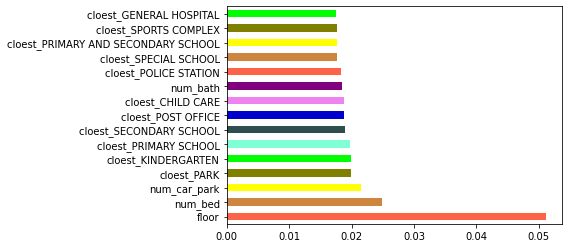

In [22]:
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.show()

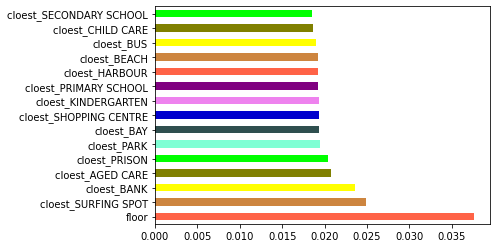

In [23]:
rf = RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(X, y)

rf_feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_feat_importances.nlargest(15).plot(kind='barh',color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.show()

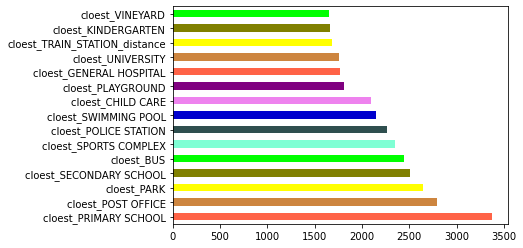

In [24]:
lgb_selector = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                              reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
lgb_selector.fit(X, y)
lgb_feat_importances = pd.Series(lgb_selector.feature_importances_, index=X.columns)
lgb_feat_importances.nlargest(15).plot(kind='barh',color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.show()

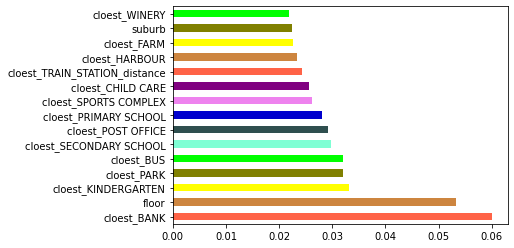

In [26]:
dt=DecisionTreeRegressor(max_depth=100)
dt.fit(X,y)

dt_feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
dt_feat_importances.nlargest(15).plot(kind='barh',color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.show()

In [28]:
X = property_df[property_df['type'] == 1].copy()
X = property_df[col_lis]
y = property_df['rent_weekly']
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=15)
chi_selector.fit(X_norm, y)
chi_scores = chi_selector.scores_
chi_pvalues = chi_selector.pvalues_
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
idx = [x for x in range(len(chi_support)) if chi_support[x]]
score = {}
for i in idx:
    score[col_lis[i]] = chi_scores[i]
print(score)

pvalue = {}
for i in idx:
    pvalue[col_lis[i]] = chi_pvalues[i]
print(pvalue)

pd.DataFrame.from_dict({'features':score.keys(), 'flat_chi2_value':score.values()}).sort_values(by=['flat_chi2_value'], ascending=False)

{'furnitured': 337.87520193832256, 'pool': 411.683649396211, 'gym': 470.6203685340238, 'POST OFFICE': 278.50359442529583, 'BAR': 323.1257806418002, 'SPORTS COMPLEX': 370.9612416196758, 'UNIVERSITY': 245.15242936719983, 'MARKET': 440.6735061157669, 'PRISON': 280.8483981454798, 'BOTANIC GARDENS': 377.9231475204045, 'SPECIALISED HOSPITAL': 270.04275121613745, 'BANK': 423.93905745138017, 'AIRPORT': 265.9485149357361, 'TRAM STATION': 361.7166805637459, 'Commercial': 267.8671762048476}
{'furnitured': 6.5274812019246514e-09, 'pool': 1.8730038623850685e-16, 'gym': 1.7304404709667688e-23, 'POST OFFICE': 0.000288383414893084, 'BAR': 1.278831760349823e-07, 'SPORTS COMPLEX': 4.3394908837676094e-12, 'UNIVERSITY': 0.020512837298848535, 'MARKET': 8.080540767763871e-20, 'PRISON': 0.00020275639302502416, 'BOTANIC GARDENS': 8.401018788117538e-13, 'SPECIALISED HOSPITAL': 0.0009734716735017774, 'BANK': 7.481273516333391e-18, 'AIRPORT': 0.0016993160747771228, 'TRAM STATION': 3.642666242704972e-11, 'Commerc

,features,flat_chi2_value
2,gym,470.620369
7,MARKET,440.673506
11,BANK,423.939057
1,pool,411.683649
9,BOTANIC GARDENS,377.923148
5,SPORTS COMPLEX,370.961242
13,TRAM STATION,361.716681
0,furnitured,337.875202
4,BAR,323.125781
8,PRISON,280.848398


In [29]:
X = property_df[property_df['type'] == 3].copy()
X = property_df[col_lis]
y = property_df['rent_weekly']
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=15)
chi_selector.fit(X_norm, y)
chi_scores = chi_selector.scores_
chi_pvalues = chi_selector.pvalues_
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
idx = [x for x in range(len(chi_support)) if chi_support[x]]
score = {}
for i in idx:
    score[col_lis[i]] = chi_scores[i]
print(score)

pvalue = {}
for i in idx:
    pvalue[col_lis[i]] = chi_pvalues[i]
print(pvalue)

pd.DataFrame.from_dict({'features':score.keys(), 'house_chi2_value':score.values()}).sort_values(by=['house_chi2_value'], ascending=False)

{'furnitured': 337.87520193832256, 'pool': 411.683649396211, 'gym': 470.6203685340238, 'POST OFFICE': 278.50359442529583, 'BAR': 323.1257806418002, 'SPORTS COMPLEX': 370.9612416196758, 'UNIVERSITY': 245.15242936719983, 'MARKET': 440.6735061157669, 'PRISON': 280.8483981454798, 'BOTANIC GARDENS': 377.9231475204045, 'SPECIALISED HOSPITAL': 270.04275121613745, 'BANK': 423.93905745138017, 'AIRPORT': 265.9485149357361, 'TRAM STATION': 361.7166805637459, 'Commercial': 267.8671762048476}
{'furnitured': 6.5274812019246514e-09, 'pool': 1.8730038623850685e-16, 'gym': 1.7304404709667688e-23, 'POST OFFICE': 0.000288383414893084, 'BAR': 1.278831760349823e-07, 'SPORTS COMPLEX': 4.3394908837676094e-12, 'UNIVERSITY': 0.020512837298848535, 'MARKET': 8.080540767763871e-20, 'PRISON': 0.00020275639302502416, 'BOTANIC GARDENS': 8.401018788117538e-13, 'SPECIALISED HOSPITAL': 0.0009734716735017774, 'BANK': 7.481273516333391e-18, 'AIRPORT': 0.0016993160747771228, 'TRAM STATION': 3.642666242704972e-11, 'Commerc

,features,house_chi2_value
2,gym,470.620369
7,MARKET,440.673506
11,BANK,423.939057
1,pool,411.683649
9,BOTANIC GARDENS,377.923148
5,SPORTS COMPLEX,370.961242
13,TRAM STATION,361.716681
0,furnitured,337.875202
4,BAR,323.125781
8,PRISON,280.848398
